In [214]:
# imports
import os
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from nilearn import plotting, datasets
from tqdm import tqdm
import pandas as pd
from pycocotools.coco import COCO
from collections import Counter
import random
import ast

In [215]:
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Times New Roman'
make_coco_metas = False

In [216]:
ROOT_DIR = '/Users/syrkis/virian/projects/neuroscope'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
COCO_PATH = os.path.join(DATA_DIR, 'nsd_stim_info_merged.csv')
ANNOT_PATH = os.path.join(DATA_DIR, 'annotations')

In [217]:
IMAGE_DIM = 32  # for resizing images

## coco

In [218]:
TRAIN_CAT_FILE = os.path.join(ANNOT_PATH, 'instances_train2017.json')
VAL_CAT_FILE = os.path.join(ANNOT_PATH, 'instances_val2017.json')
TRAIN_CAP_FILE = os.path.join(ANNOT_PATH, 'captions_train2017.json')
VAL_CAP_FILE = os.path.join(ANNOT_PATH, 'captions_val2017.json')

In [219]:

def extract_meta(captions_coco, instances_coco, merged_anns, nds_coco_img_ids):
    valid_ids = set(instances_coco.getImgIds())
    for img_id in tqdm(valid_ids):
        anns = captions_coco.loadAnns(captions_coco.getAnnIds(imgIds=img_id))
        captions = [ann['caption'] for ann in anns]
        innstances = instances_coco.loadAnns(instances_coco.getAnnIds(imgIds=img_id))
        categories = list(set([instance['category_id'] for instance in innstances]))
        supercategory = [entry['supercategory'] for entry in instances_coco.loadCats(categories)]
        merged_anns.append({ 'cocoId': img_id, 'captions': captions, 'categories': categories, 'supercategory': supercategory })
    return merged_anns


In [220]:
if make_coco_metas:
    train_instances_coco = COCO(TRAIN_CAT_FILE)
    val_instances_coco = COCO(VAL_CAT_FILE)
    train_captions_coco = COCO(TRAIN_CAP_FILE)
    val_captions_coco = COCO(VAL_CAP_FILE)

    merged_anns = []
    nsd_coco = pd.read_csv(COCO_PATH)
    nsd_coco_img_ids = set(nsd_coco['cocoId'])

    valid_ids = set(val_instances_coco.getImgIds()).intersection(nsd_coco_img_ids)
    merged_anns = extract_meta(val_captions_coco, val_instances_coco, merged_anns, nsd_coco_img_ids)
    merged_anns = extract_meta(train_captions_coco, train_instances_coco, merged_anns, nsd_coco_img_ids)
    df = pd.DataFrame(merged_anns)
    df.to_csv(os.path.join(DATA_DIR, 'coco_meta_data.csv'), index=False)
    
    del train_instances_coco, val_instances_coco, train_captions_coco, val_captions_coco, merged_anns, nsd_coco, df

In [221]:
coco_df = pd.read_csv(os.path.join(DATA_DIR, 'coco_meta_data.csv'), index_col='cocoId')
coco_df['categories'] = coco_df['categories'].apply(lambda x: ast.literal_eval(x))
coco_df['supercategory'] = coco_df['supercategory'].apply(lambda x: ast.literal_eval(x))
coco_df['captions'] = coco_df['captions'].apply(lambda x: ast.literal_eval(x))
nsd_df = pd.read_csv(os.path.join(DATA_DIR, 'nsd_stim_info_merged.csv'))
meta_data = coco_df.loc[nsd_df['cocoId']]

In [308]:
def get_split_idxs(split):
    if split == 'train':
        split = 'train2017'
    elif split == 'valid':
        split = 'val2017'
    mask = nsd_df['cocoSplit'] == split
    return nsd_df[mask].index.values

get_split_idxs('valid')

array([   0,    1,    2, ..., 2947, 2948, 2949])

In [310]:
nsd_df

,Unnamed: 0,cocoId,cocoSplit,cropBox,loss,nsdId,flagged,BOLD5000,shared1000,subject1,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
0,0,532481,val2017,"(0, 0, 0.1671875, 0.1671875)",0.100000,0,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
1,1,245764,val2017,"(0, 0, 0.125, 0.125)",0.000000,1,False,False,False,0,...,0,0,0,0,13985,14176,28603,0,0,0
2,2,385029,val2017,"(0, 0, 0.125, 0.125)",0.000000,2,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
3,3,311303,val2017,"(0, 0, 0.16640625, 0.16640625)",0.125000,3,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
4,4,393226,val2017,"(0, 0, 0.125, 0.125)",0.133333,4,False,False,False,0,...,0,13720,22861,23023,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72995,72995,518071,train2017,"(0, 0, 0.125, 0.125)",0.000000,72995,False,False,False,0,...,0,0,0,0,0,0,0,6083,11650,26531
72996,72996,255930,train2017,"(0, 0, 0.125, 0.125)",0.125000,72996,False,False,False,0,...,0,0,0,0,0,0,0,10402,10434,10625
72997,72997,255934,train2017,"(0, 0, 0.1, 0.1)",0.000000,72997,False,False,False,0,...,0,0,0,0,0,0,0,0,0,0
72998,72998,518080,train2017,"(0.125, 0.125, 0, 0)",0.000000,72998,False,False,False,0,...,0,0,0,0,5585,11846,14495,0,0,0


In [442]:
coco = COCO(VAL_CAT_FILE)
cats = coco.loadCats(coco.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in cats}
cat_name_to_id = {cat['name']: cat['id'] for cat in cats}

# for one-hot encoding
coco_cat_id_to_vec_index = {cat_id: i for i, cat_id in enumerate(cat_id_to_name.keys())}
vec_index_to_coco_cat_id = {i: cat_id for i, cat_id in enumerate(cat_id_to_name.keys())}

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [443]:
cats

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

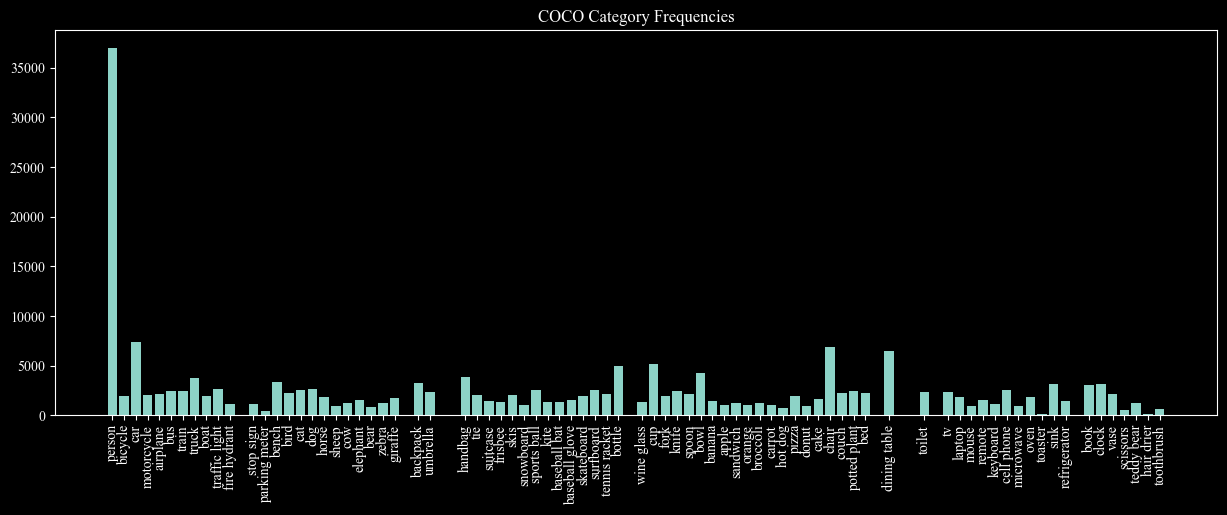

In [293]:
# TODO: plot both validation and training histograms to confirm that they are similar
flat_cat_list = [e for l in coco_df.loc[nsd_df.cocoId].categories.values.tolist() for e in l]
freqs = Counter(flat_cat_list)
#make histogram
plt.figure(figsize=(15, 5))
plt.bar(freqs.keys(), freqs.values())
x_labels = [cat_id_to_name[cat_id] for cat_id in freqs.keys()]
plt.xticks(list(freqs.keys()), x_labels, rotation=90)
plt.title('COCO Category Frequencies')
plt.show()

## data

In [294]:
# get nsd files for particular subject
def get_files(subject):  # can only load train data (from which valid is made). TODO: add test flag
    lh_fmri_file = os.path.join(DATA_DIR, subject, 'training_split/training_fmri/lh_training_fmri.npy')
    rh_fmri_file = os.path.join(DATA_DIR, subject, 'training_split/training_fmri/rh_training_fmri.npy')
    image_dir = os.path.join(DATA_DIR, subject, 'training' + '_split', 'training' + '_images')
    image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
    return lh_fmri_file, rh_fmri_file, image_files

In [295]:
def preprocess(image):
    image = image.resize((IMAGE_DIM, IMAGE_DIM))
    image = np.array(image)
    image = image / 255.0
    image = image.astype(np.float32)
    return image

In [344]:
def c_to_one_hot(categories):  # there are 80 categories, but the ids range from 1-90 (skipping 10) TODO: deal with this perhaps
    one_hot = np.zeros(len(cat_id_to_name))
    for cat in categories:
        one_hot[coco_cat_id_to_vec_index[cat]] = 1
    return one_hot

def file_name_has_valid_coco_id(file_name, coco_ids):
    id_from_file = file_name.split('/')[-1].split('.')[0].split('_')[-1].split('-')[-1]
    return int(id_from_file) in coco_ids


In [345]:
# get batch for subject. TODO: make subject mixed batches. fmri dimensions might be subject specific.
def get_subject_batches(subject, batch_size, n=None, split='train'):
    _, _, image_files = get_files(subject)
    n = n if n else len(image_files)
    # lh, rh = np.load(lh_file), np.load(rh_file)
    split_idxs = set(get_split_idxs(split))
    image_files = [f for f in image_files if file_name_has_valid_coco_id(f, split_idxs)]  # I think this is right, but fuuuck
    if n < len(image_files):
        image_files = random.sample(image_files, n)
    images = []
    # look up categories for each image
    coco_ids = [int(f.split('.')[0].split('-')[-1]) for f in image_files]
    categories = meta_data.iloc[coco_ids]['categories'].values
    supers = meta_data.iloc[coco_ids]['supercategory'].values
    captions = meta_data.iloc[coco_ids]['captions'].values
    for image_file in tqdm(image_files):
        images.append(np.array(preprocess(Image.open(image_file))))
    images = jnp.array(images)
    while True:
        perm = np.random.permutation(len(image_files))
        for i in range(0, len(image_files), batch_size):
            idxs = perm[i:i + batch_size]
            # sample random category from each category list
            cat = jnp.array([c_to_one_hot(c) for c in categories[idxs]])
            yield images[idxs], cat, supers[idxs], captions[idxs]

In [346]:
train_loader = get_subject_batches('subj05', 16, n=100, split='train')
valid_loader = get_subject_batches('subj05', 16, n=100, split='valid')

In [347]:
img, cat, sup, cap = next(valid_loader)
img, cat, sup, cap = next(train_loader)

100%|██████████| 100/100 [00:02<00:00, 47.00it/s]


In [348]:
cat

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

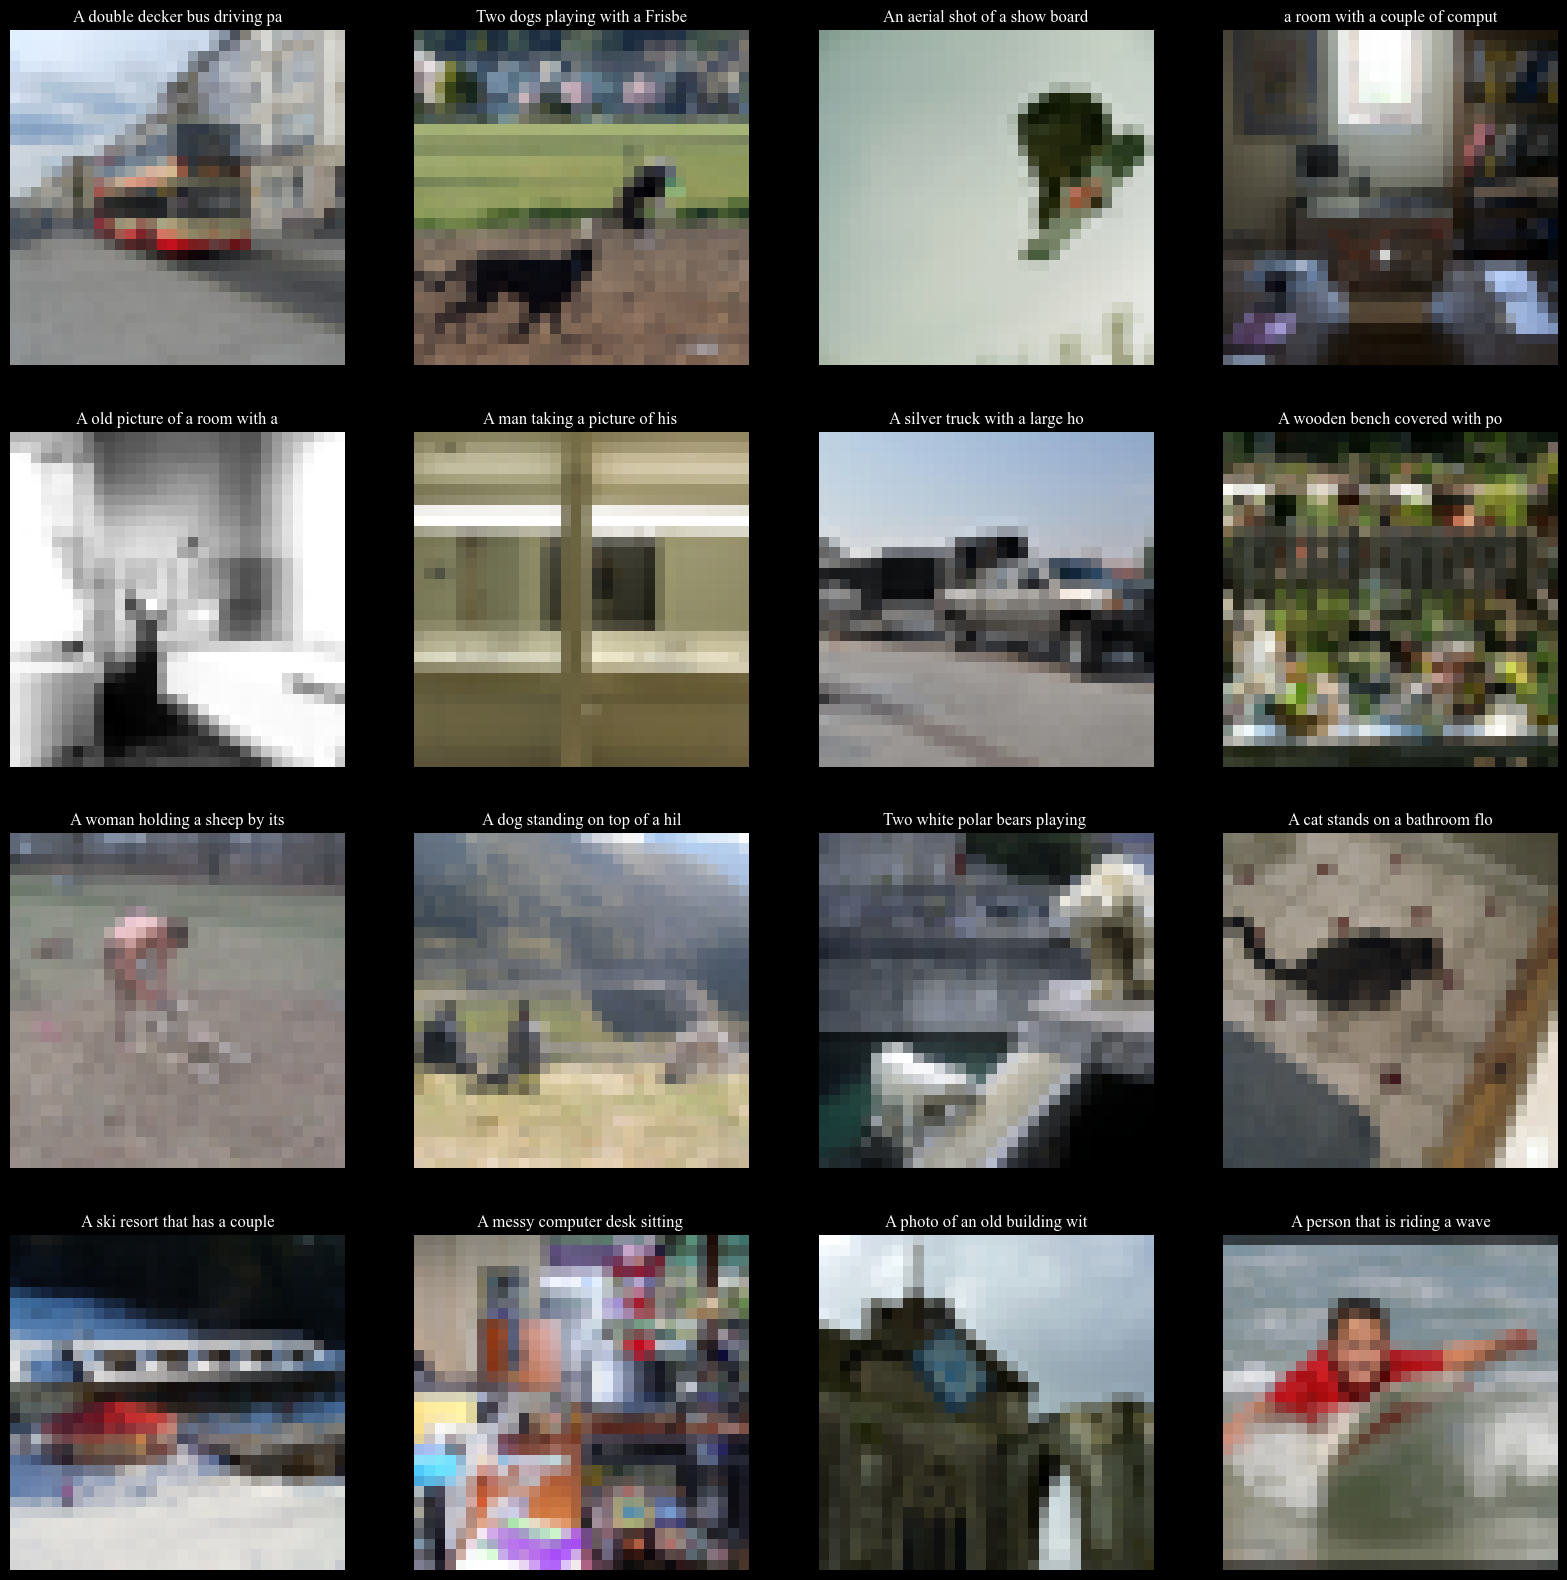

In [325]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(img[i])
    ax.set_title(cap[i][0][:30])
    ax.axis('off')
plt.show()

## model

In [326]:
# init params
def init_mlp(layer_sizes, rng):
    params = []
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        w = jax.random.normal(rng, (n_in, n_out)) * jnp.sqrt(2 / n_in)
        b = jax.random.normal(rng, (n_out,)) * jnp.sqrt(2 / n_in)
        params.append((w, b))
    return params

def relu(x):
    return jnp.maximum(0, x)

def predict_mlp(params, x):
    activations = x
    for w, b in params:
        outputs = jnp.dot(activations, w) + b
        activations = relu(outputs)
    return jax.nn.sigmoid(outputs)

def loss_fn(params, x, y):
    pred = predict_mlp(params, x)  # batch_size x image_dim
    return -jnp.mean(y * jnp.log(pred) + (1 - y) * jnp.log(1 - pred))

## evaluation

In [327]:
def accuracy(params, x, y):
    pred = predict_mlp(params, x)
    return jnp.mean((pred > 0.5) == y)

In [379]:
def evaluate(params, train_loader, valid_loader, metrics, steps=5):
    # metrics is dict of lists of val loss val acc train loss train acc
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    for _ in range(steps):
        x, y, _, _ = next(train_loader)
        x = x.mean(3).reshape(x.shape[0], -1)   # TODO: this is a hack cos I'm flattening, but I don't wanna fltten
        train_loss.append(loss_fn(params, x, y))
        train_acc.append(accuracy(params, x, y))
    for _ in range(steps):
        x, y, _, _ = next(valid_loader)
        x = x.mean(3).reshape(x.shape[0], -1)   # TODO: this is a hack cos I'm flattening, but I don't wanna fltten
        valid_loss.append(loss_fn(params, x, y))
        valid_acc.append(accuracy(params, x, y))
    metrics['train_loss'].append(np.mean(train_loss))
    metrics['train_acc'].append(np.mean(train_acc))
    metrics['valid_loss'].append(np.mean(valid_loss))
    metrics['valid_acc'].append(np.mean(valid_acc))
    return metrics


In [380]:
def plot_metrics(metrics):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5), dpi=100)
    axes[0].plot(metrics['train_loss'], label='train')
    axes[0].plot(metrics['valid_loss'], label='valid')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[1].plot(metrics['train_acc'], label='train')
    axes[1].plot(metrics['valid_acc'], label='valid')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    plt.show()

## training

In [364]:
train_loader = get_subject_batches('subj05', 16, n=1000)
valid_loader = get_subject_batches('subj05', 16, n=100, split='valid')

In [417]:
rng = jax.random.PRNGKey(0)
params = init_mlp([IMAGE_DIM ** 2, 512, 512, 80], rng)
metrics = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)

In [418]:
@jax.jit
def update(params, x, y, opt, opt_state):
    grads = grad(loss_fn)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

In [439]:
steps = 500
pbar = tqdm(range(steps))
for i in pbar:
    image, cats, supers, caps = next(train_loader)
    image = image.mean(3).reshape(-1, IMAGE_DIM ** 2)
    params, opt_state = update(params, image, cats, opt_state)
    if i % (steps // 50) == 0:
        metrics = evaluate(params, train_loader, valid_loader, metrics)

100%|██████████| 500/500 [00:05<00:00, 96.83it/s] 


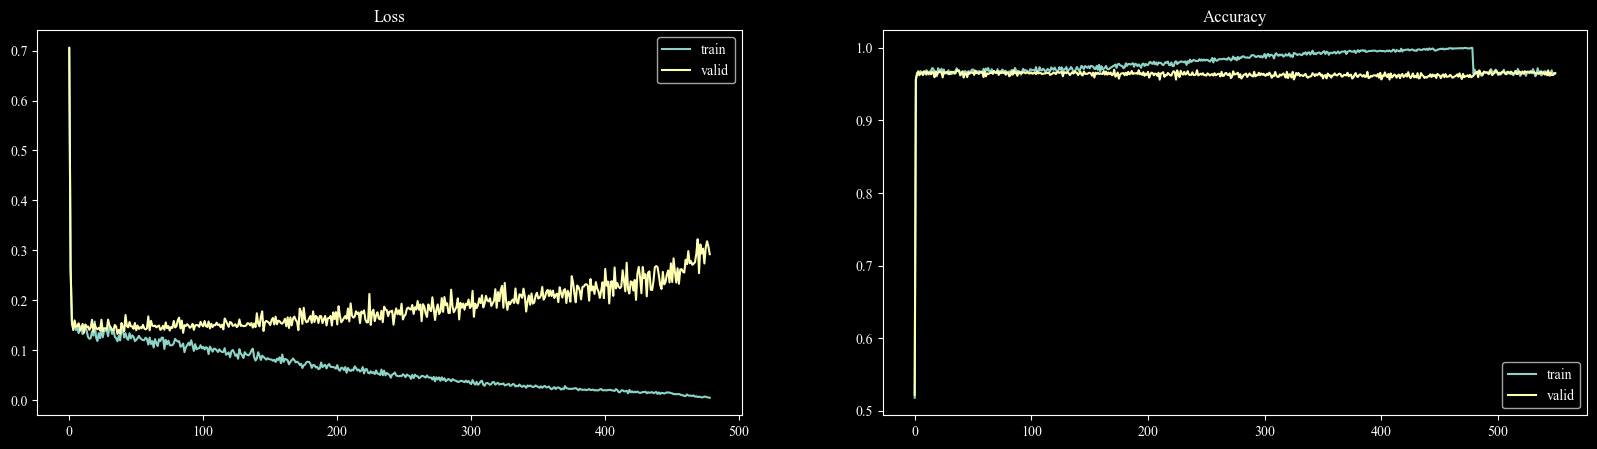

In [440]:
plot_metrics(metrics)